In [29]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.datasets import load_whas500

In [2]:
df = pd.read_csv(Path.cwd() / 'HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df[['YearsAtCompany','Attrition']].head()

,YearsAtCompany,Attrition
0,6,Yes
1,10,No
2,0,Yes
3,8,No
4,2,No


In [4]:
encoder = LabelEncoder()
df['Attrition'] = encoder.fit_transform(df['Attrition'])

In [5]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['YearsAtCompany'], event_observed=df['Attrition'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1470 total observations, 1233 right-censored observations>

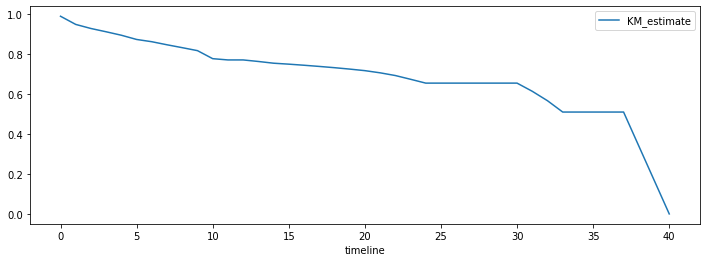

In [6]:
kmf.survival_function_.plot(figsize=(12, 4))
plt.show()

[]

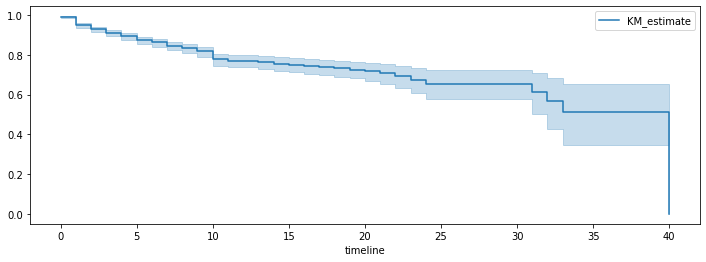

In [7]:
kmf.plot_survival_function(figsize=(12, 4))
plt.plot()

In [8]:
env_low = df['EnvironmentSatisfaction'].isin([1, 2])
env_high = df['EnvironmentSatisfaction'].isin([3, 4])

In [9]:
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=df[env_low]['YearsAtCompany'], event_observed=df[env_low]['Attrition'])
kmf2 = KaplanMeierFitter()
kmf2.fit(durations=df[env_high]['YearsAtCompany'], event_observed=df[env_high]['Attrition'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 899 total observations, 777 right-censored observations>

[]

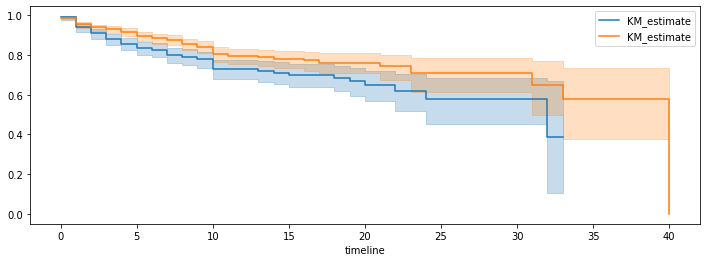

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
kmf1.plot_survival_function(ax=ax)
kmf2.plot_survival_function(ax=ax)
plt.plot()

In [11]:
wlb_low = df['WorkLifeBalance'].isin([1, 2])
wlb_high = df['WorkLifeBalance'].isin([3, 4])

In [12]:
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=df[wlb_low]['YearsAtCompany'], event_observed=df[wlb_low]['Attrition'])
kmf2 = KaplanMeierFitter()
kmf2.fit(durations=df[wlb_high]['YearsAtCompany'], event_observed=df[wlb_high]['Attrition'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1046 total observations, 892 right-censored observations>

[]

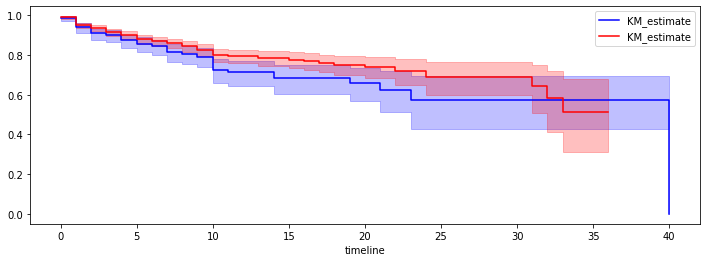

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
kmf1.plot_survival_function(ax=ax, color='b')
kmf2.plot_survival_function(ax=ax, color='r')
plt.plot()

In [14]:
output = logrank_test(durations_A=df[wlb_low]['YearsAtCompany'], event_observed_A=df[wlb_low]['Attrition'],
durations_B=df[wlb_high]['YearsAtCompany'], event_observed_B=df[wlb_high]['Attrition'])
output.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.40 0.04      4.80

In [15]:
columns_selected = ['Attrition', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PercentSalaryHike',
                    'RelationshipSatisfaction', 'StockOptionLevel',  'TrainingTimesLastYear', 'YearsAtCompany']

In [16]:
coxph = CoxPHFitter()
coxph.fit(df[columns_selected], duration_col='YearsAtCompany', event_col='Attrition')

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>

In [17]:
df_new = df[columns_selected].loc[df['Attrition'] == 0]
df_new_obs = df_new['YearsAtCompany']
preds = coxph.predict_survival_function(df_new, conditional_after=df_new_obs)
pd.DataFrame(preds).head(11)

,1,3,4,5,6,7,8,9,10,11,...,1459,1460,1462,1463,1464,1465,1466,1467,1468,1469
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.986432,0.954723,0.960284,0.962204,0.988253,0.976696,0.967621,0.991449,0.980443,0.932105,...,0.974752,0.935606,0.982590,0.863102,0.936199,0.996076,0.993213,0.980338,0.917680,0.982232
2.0,0.986432,0.832633,0.916395,0.921246,0.978083,0.956741,0.961087,0.981883,0.952241,0.918711,...,0.958889,0.847959,0.959461,0.837336,0.897422,0.990305,0.985605,0.960066,0.901594,0.970999
3.0,0.967805,0.809508,0.861182,0.810189,0.966473,0.934212,0.961087,0.954170,0.923440,0.918711,...,0.935918,0.764583,0.930067,0.837336,0.843040,0.984269,0.963477,0.937681,0.901594,0.954632
4.0,0.945323,0.809508,0.827520,0.789045,0.951264,0.905105,0.952042,0.948562,0.891969,0.900342,...,0.912341,0.680258,0.898352,0.802662,0.789370,0.977498,0.958984,0.874576,0.879617,0.937709
5.0,0.932830,0.778306,0.780170,0.789045,0.941632,0.886908,0.941008,0.948562,0.805153,0.878198,...,0.886434,0.481727,0.898352,0.761880,0.732870,0.957773,0.958984,0.862123,0.853256,0.918962
6.0,0.915764,0.741487,0.733267,0.760458,0.927576,0.860685,0.934819,0.940792,0.788358,0.865906,...,0.814144,0.448692,0.898352,0.739722,0.588544,0.953762,0.952749,0.862123,0.838687,0.865759
7.0,0.896696,0.721424,0.683692,0.726633,0.913012,0.833928,0.926297,0.931300,0.788358,0.849131,...,0.800010,0.448692,0.898352,0.710034,0.562563,0.953762,0.945117,0.845040,0.818878,0.855195
8.0,0.873145,0.694475,0.556009,0.708160,0.896843,0.804717,0.916680,0.925970,0.765505,0.830410,...,0.800010,0.406345,0.898352,0.677649,0.562563,0.948194,0.940824,0.824443,0.796873,0.855195
9.0,0.842240,0.664989,0.532844,0.683295,0.850746,0.724291,0.904658,0.918623,0.738239,0.807321,...,0.780697,0.359594,0.898352,0.638795,0.528213,0.941372,0.934899,0.813008,0.769885,0.840668


<AxesSubplot:>

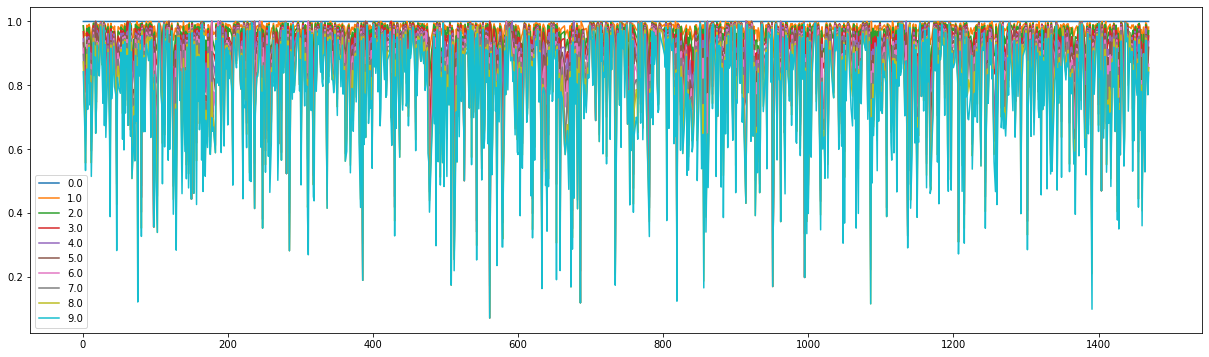

In [18]:
pd.DataFrame(preds).head(10).T.plot(figsize=(21, 6))

In [19]:
pd.concat([pd.DataFrame(preds).idxmin(axis=1), pd.DataFrame(preds).min(axis=1).round(3)], axis=1)

,0,1
0.0,1,1.000
1.0,98,0.709
2.0,98,0.502
3.0,995,0.334
4.0,995,0.198
5.0,951,0.169
6.0,561,0.071
7.0,561,0.071
8.0,561,0.071
9.0,561,0.071


In [20]:
coxph.check_assumptions(df[columns_selected])

Proportional hazard assumption looks okay.


[]

<AxesSubplot:xlabel='log(HR) (95% CI)'>

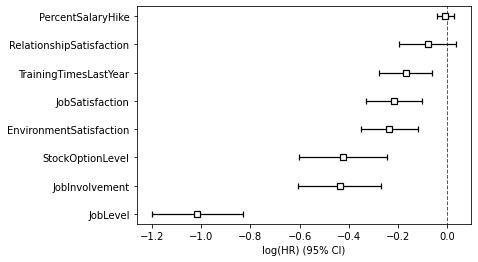

In [21]:
coxph.plot()

In [22]:
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1449.16
         time fit was run = 2023-08-10 03:19:08 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
EnvironmentSatisfaction   -0.24       0.79       0.06            -0.35            -0.12                 0.70                 0.89
JobInvolvement            -0.44       0.65       0.09            -0.61            -0.27                 0.55                 0.76
JobLevel                  -1.02       0.36       0.09            -1.20            -0.83                 0.30                 0.44
JobSatisfaction           -0.22       0.81       0.06            -0.33            -0.10                 0.72                 0.90
PercentSalaryHike         -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
RelationshipSatisfaction  -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
StockOptionLevel          -0.42       0.65       0.09            -0.60            -0.24                 0.55                 0.78
TrainingTimesLastYear     -0.17       0.85       0.05            -0.28            -0.06                 0.76                 0.94

                           cmp to      z      p   -log2(p)
covariate                                                 
EnvironmentSatisfaction      0.00  -4.00 <0.005      13.92
JobInvolvement               0.00  -5.08 <0.005      21.31
JobLevel                     0.00 -10.77 <0.005      87.49
JobSatisfaction              0.00  -3.77 <0.005      12.61
PercentSalaryHike            0.00  -0.44   0.66       0.60
RelationshipSatisfaction     0.00  -1.34   0.18       2.46
StockOptionLevel             0.00  -4.63 <0.005      18.04
TrainingTimesLastYear        0.00  -3.07 <0.005       8.84
---
Concordance = 0.79
Partial AIC = 2914.33
log-likelihood ratio test = 249.92 on 8 df
-log2(p) of ll-ratio test = 161.93

In [23]:
cox_cv_result = k_fold_cross_validation(coxph, df[columns_selected], duration_col='YearsAtCompany', event_col='Attrition', k=5)
cox_cv_result

[-0.7557632128427967,
 -0.7284394629628292,
 -0.7246558651891781,
 -0.7323555479358752,
 -0.7427475536482314]

In [27]:
gbr = GradientBoostingSurvivalAnalysis()
gbr_gcv = GridSearchCV(gbr, {}, cv=KFold(n_splits=5))

In [45]:
X = df[columns_selected].drop(['Attrition', 'YearsAtCompany'], axis=1)
y = df[columns_selected].apply(lambda df: (df[columns_selected]['Attrition'], df[columns_selected]['YearsAtCompany']), axis=1).to_numpy(dtype=[('event', 'bool'), ('time', 'float64')])
y

array([( True,  6.), (False, 10.), ( True,  0.), ..., (False,  6.),
       (False,  9.), (False,  4.)],
      dtype=[('event', '?'), ('time', '<f8')])

In [46]:
gbr_result = gbr_gcv.fit(X, y)
print('C-index = ', gbr_result.best_score_)

C-index =  0.7909368154953154


In [47]:
gbr = GradientBoostingSurvivalAnalysis().fit(X, y)
gbr.staged_predict(X)

<generator object GradientBoostingSurvivalAnalysis.staged_predict at 0x000001FD5A725C40>

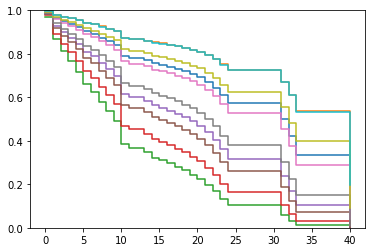

In [49]:
surv_funcs = gbr.predict_survival_function(X.iloc[:10])
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()

In [51]:
gbr.predict(X)

array([-0.07560766, -0.63340548,  1.32544983, ..., -0.55613608,
       -0.31407972, -0.14580822])

In [53]:
gbr.score(X, y)

0.8202453878954974